# May 12th, 2021

**Motivation**: Community structure (Louvain + Leiden + bp + SVINET + centralities + memships). </br>

In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    percentile: int = 20,
    min_com_size: int = 3,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            msg1 = 'pearson\n(th = {:.2f})\n'
            msg1 = msg1.format(np.min(pearson[percentile][pearson[percentile] > 0]))
            msg2 = 'spearman\n(th = {:.2f})\n'
            msg2 = msg2.format(np.min(spearman[percentile][spearman[percentile] > 0]))
            axes[0, ii].set_ylabel(msg1, fontsize=12)
            axes[1, ii].set_ylabel(msg2, fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    figsize=None,
    colorbar=False,):
    
    percentiles = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(percentiles)) if figsize is None else figsize
    fig, axes = plt.subplots(len(percentiles), 2, figsize=figsize)

    for ii, perc in enumerate(sorted(percentiles, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 0].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=12, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 1].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=12, y=1.03)
        axes[ii, 1].set_ylabel('Using {:d} {:s} \n'.format(perc, '%'), fontsize=12)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(
    organized_data: dict,
    include: Union[range, List[int]] = None,
    config: Config = None,):
    
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = list(regions.keys())[:19] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy()
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy().astype(float)
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas': atlas,
        'atlas_limited': x,
        'contour': contour,
    }
    return output

## k-means parcellation

In [4]:
config = Config()

subject = 6
session = 1
num_kmeans_regions = 128

lowcut = 0.1
highcut = 1.0
order = 2

df = pd.DataFrame()
df_bp = pd.DataFrame()
for run in [1, 3, 5, 7]:
    load = load_organized_data(
        folder='atlas-{:d}_unfiltered_unnormalized'.format(num_kmeans_regions),
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    ca = {k: v for k, v in load['ca'].items()}
    ca_bp = {
        k: apply_bandpass(
            x=v,
            fs=config.ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order, )
        for k, v in load['ca'].items()
    }
    
    # normalize
    mean = np.mean([item.mean() for item in ca.values()])
    sd = np.mean([item.std() for item in ca.values()])
    ca_n = {k: (v - mean) / sd for k, v in ca.items()}
    
    mean = np.mean([item.mean() for item in ca_bp.values()])
    sd = np.mean([item.std() for item in ca_bp.values()])
    ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}

    df = pd.concat([df, pd.DataFrame.from_dict(ca_n)])
    df_bp = pd.concat([df_bp, pd.DataFrame.from_dict(ca_bp_n)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

atls_org = organize_atlas(load)

In [5]:
percentiles = [25, 20, 18, 15, 13, 10]
corrs = get_corrs(df, percentiles=percentiles)
corrs_bp = get_corrs(df_bp, percentiles=percentiles)

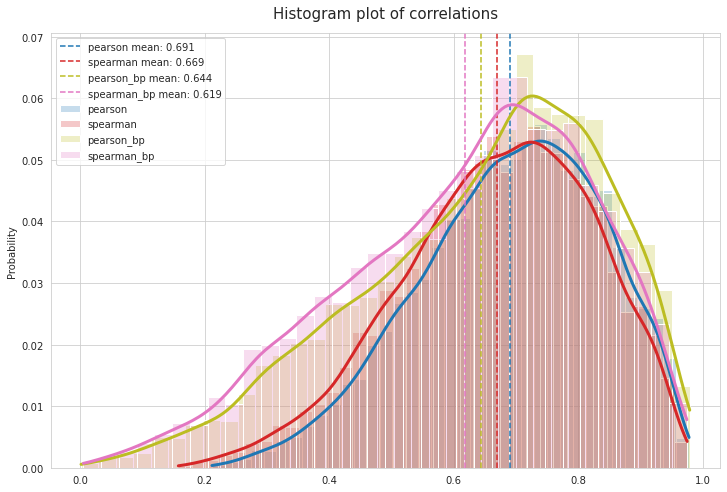

In [7]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr'],
               corrs_bp['pearson_corr'], corrs_bp['spearman_corr']],
    labels=['pearson', 'spearman', 'pearson_bp', 'spearman_bp'],
    colors=['C0', 'C3', 'C8', 'C6'],
)

In [8]:
graphs = {perc: nx.from_numpy_matrix(a) for perc, a in corrs['spearman'].items()}
graphs_bp = {perc: nx.from_numpy_matrix(a) for perc, a in corrs_bp['spearman'].items()}

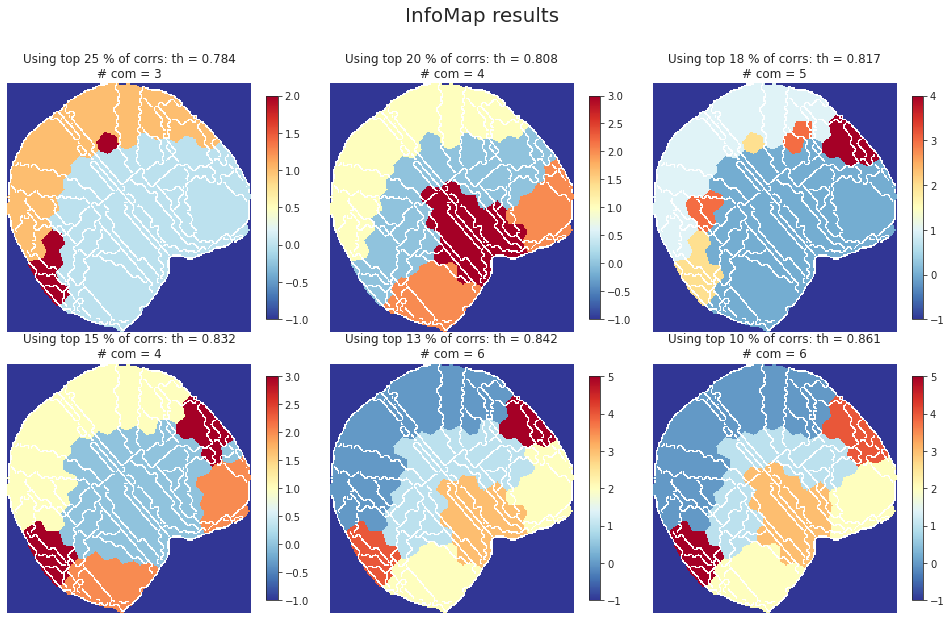

In [9]:
sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8.5))

for idx, (perc, g) in enumerate(graphs.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas_kmeans'], node_labels, min_com_size=0)
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\n# com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

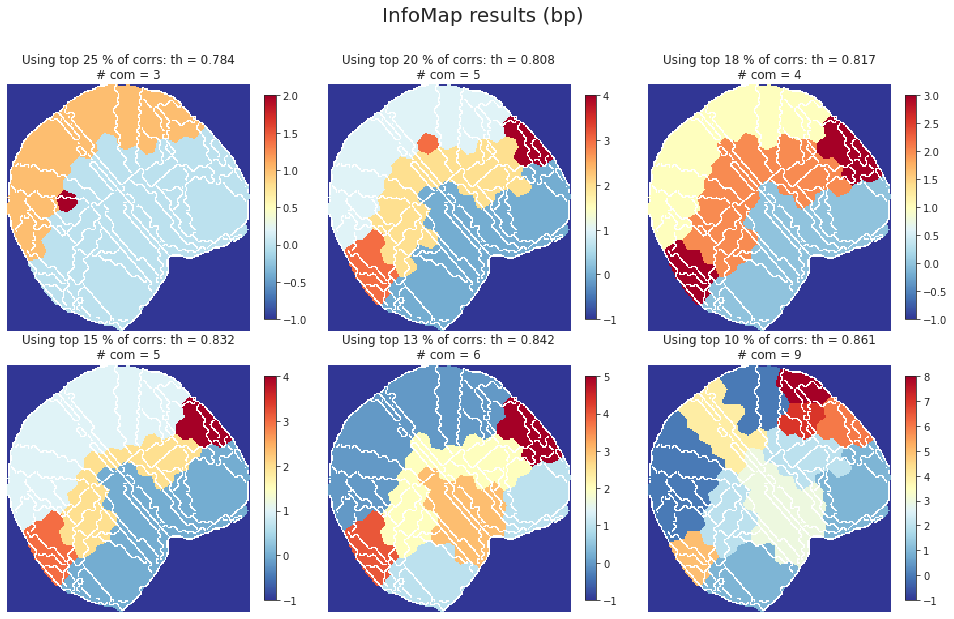

In [10]:
sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8.5))

for idx, (perc, g) in enumerate(graphs_bp.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas_kmeans'], node_labels, min_com_size=0)
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\n# com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results (bp)', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

In [12]:
results_louvain = run_louvain(graphs[18], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

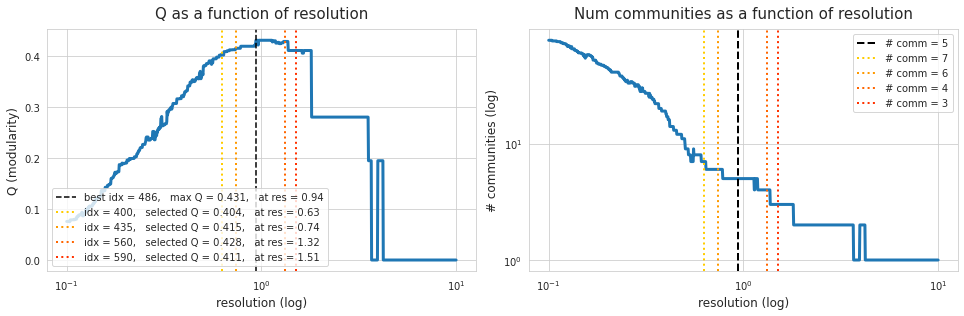

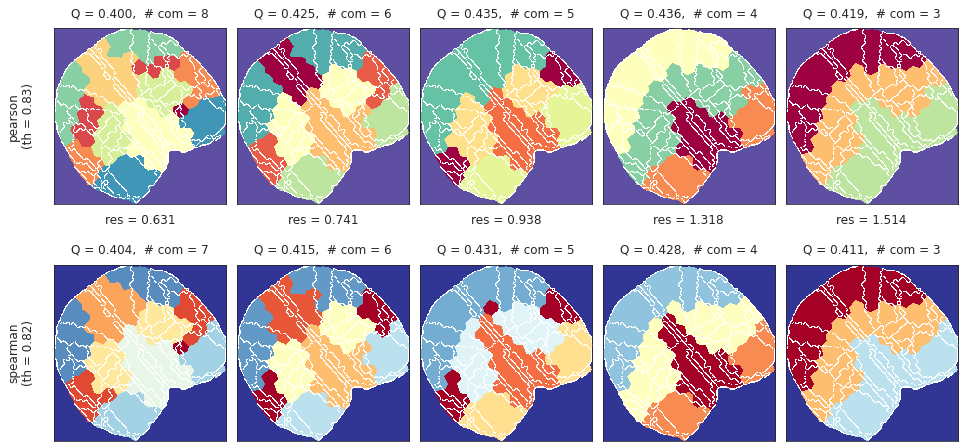

In [31]:
selected_idxs = [400, 435, 560, 590,]
fig, axes = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)
fig.savefig('LouvainResults{:d}.pdf'.format(num_kmeans_regions), dpi=300, bbox_inches='tight')

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    percentile=18,
    min_com_size=0,
    figsize=(13.5, 6.5),
    colorbar=False, )
fig.savefig('LouvainComms{:d}.pdf'.format(num_kmeans_regions), dpi=300, bbox_inches='tight')

In [34]:
results_louvain = run_louvain(graphs_bp[18], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

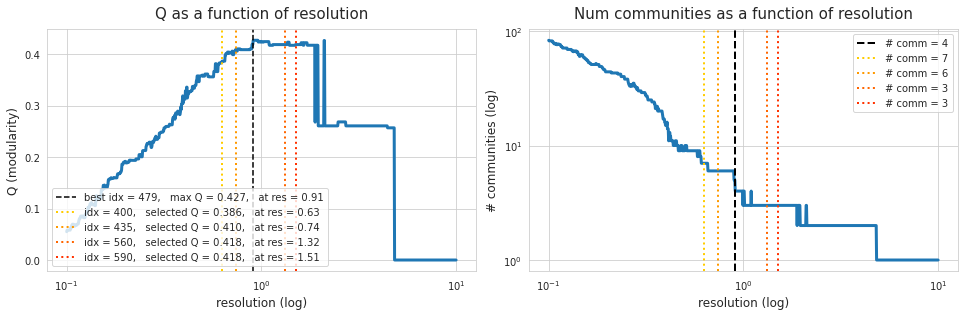

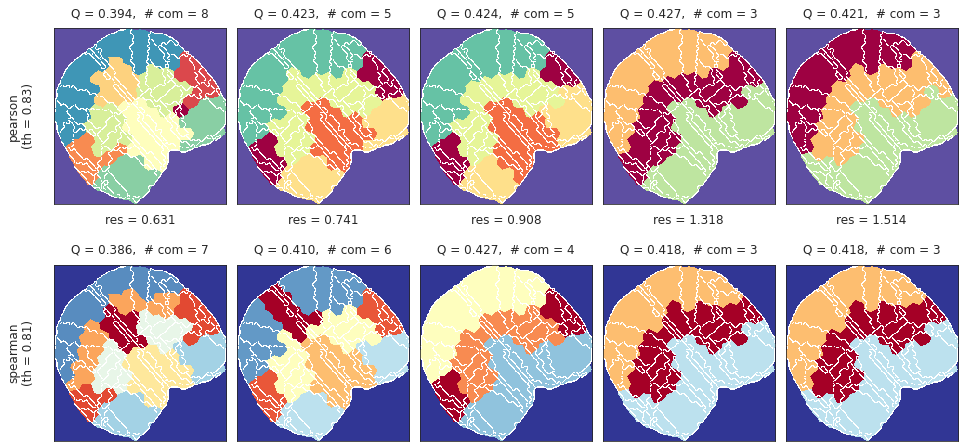

In [36]:
selected_idxs = [400, 435, 560, 590,]
fig, axes = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)
fig.savefig('LouvainResults_bp{:d}.pdf'.format(num_kmeans_regions), dpi=300, bbox_inches='tight')

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs_bp['pearson'],
    spearman=corrs_bp['spearman'],
    atlas=load['atlas_kmeans'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    percentile=18,
    min_com_size=0,
    figsize=(13.5, 6.5),
    colorbar=False, )
fig.savefig('LouvainComms_bp{:d}.pdf'.format(num_kmeans_regions), dpi=300, bbox_inches='tight')

#### Leiden

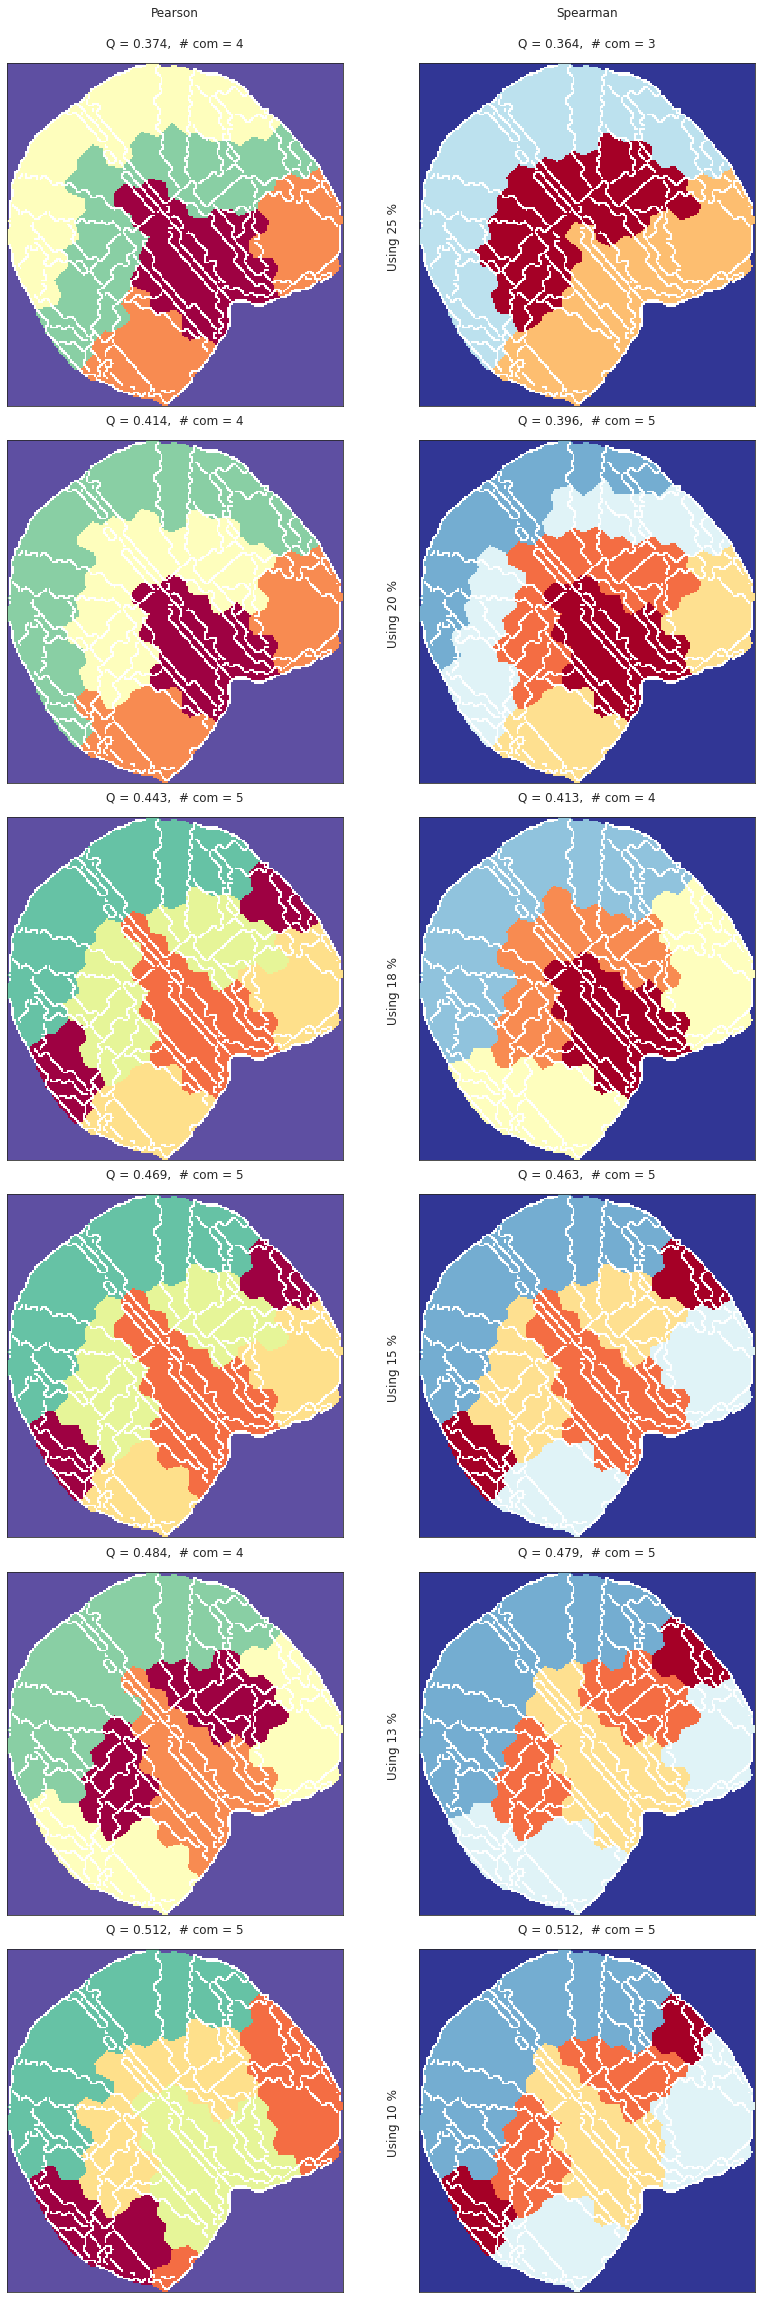

In [38]:
fig, axes = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)
fig.savefig('LeidenComms{:d}.pdf'.format(num_kmeans_regions), dpi=300, bbox_inches='tight')

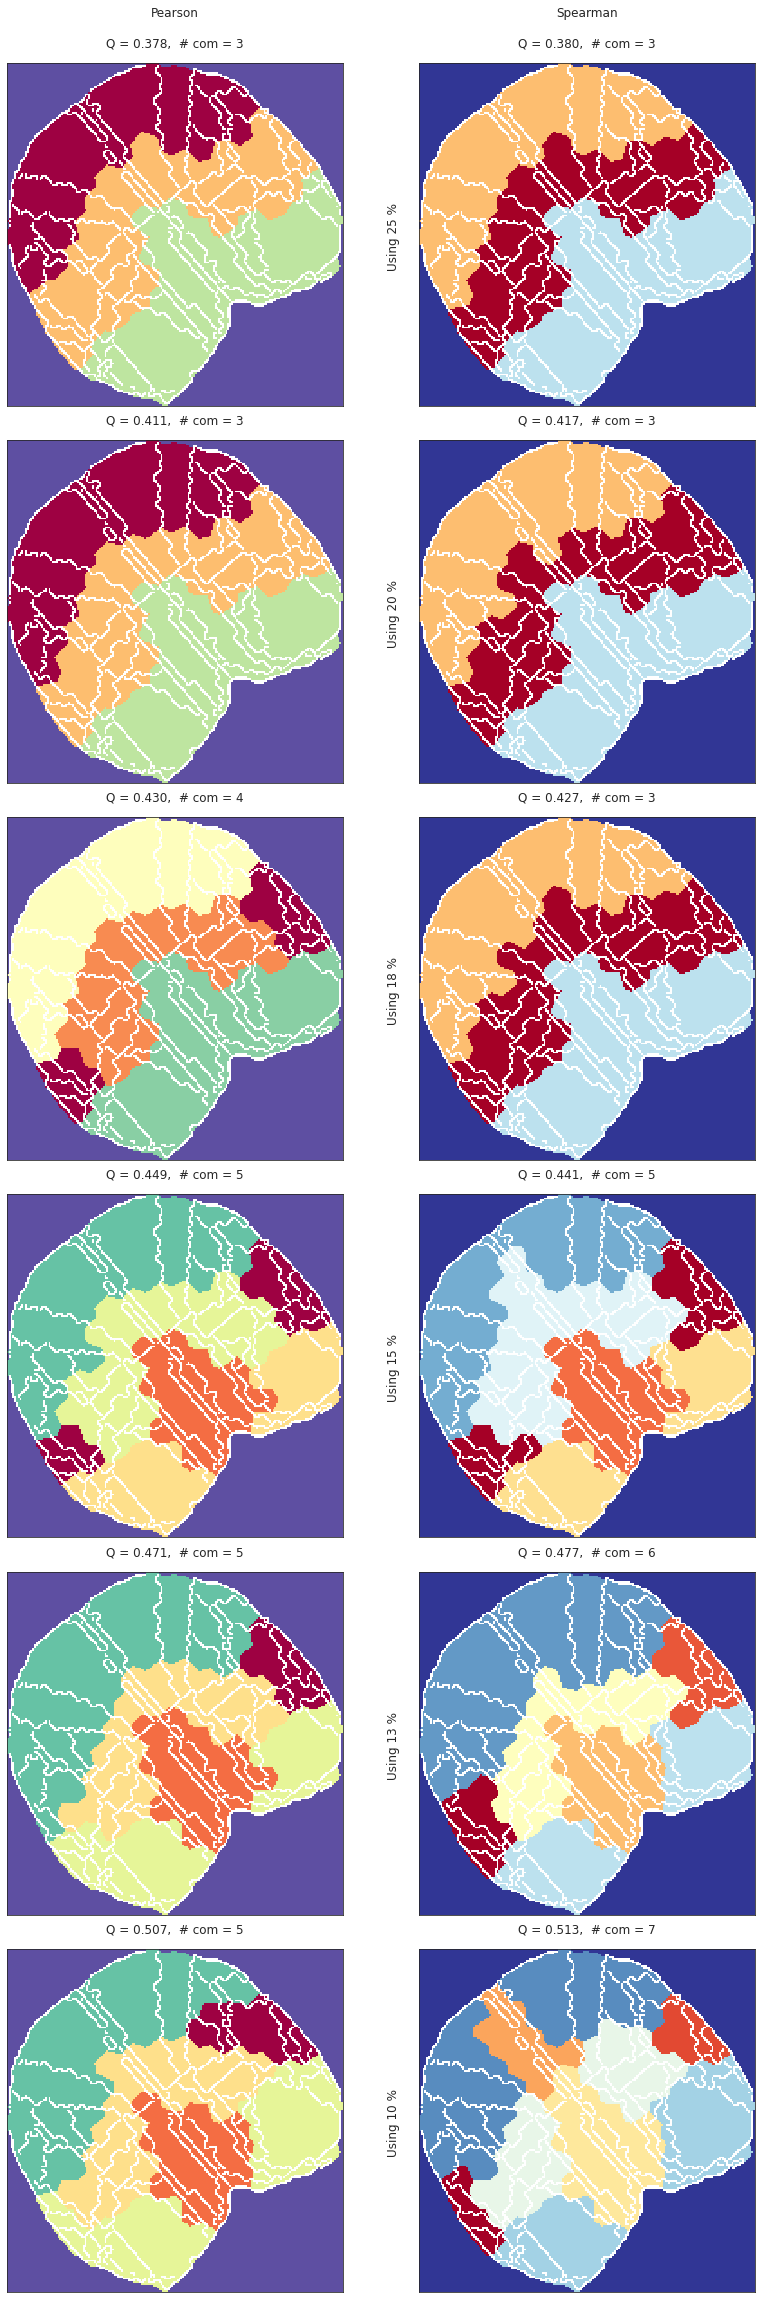

In [39]:
fig, axes = plot_leiden_communities(
    pearson=corrs_bp['pearson'],
    spearman=corrs_bp['spearman'],
    atlas=load['atlas_kmeans'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)
fig.savefig('LeidenComms_bp{:d}.pdf'.format(num_kmeans_regions), dpi=300, bbox_inches='tight')

## SVINET

In [3]:
svinet_dir = './svinet_results'

cmaps = {
    0: 'Blues',
    1: 'Reds',
    2: 'Greens',
    3: 'Greys',
    4: 'Purples',
    5: 'Oranges',
}

In [4]:
config = Config()

subject = 6
session = 1
num_kmeans_regions = 128

lowcut = 0.1
highcut = 1.0
order = 2

df = pd.DataFrame()
df_bp = pd.DataFrame()
for run in [1, 3, 5, 7]:
    load = load_organized_data(
        folder='atlas-{:d}_unfiltered_unnormalized'.format(num_kmeans_regions),
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    ca = {k: v for k, v in load['ca'].items()}
    ca_bp = {
        k: apply_bandpass(
            x=v,
            fs=config.ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order, )
        for k, v in load['ca'].items()
    }
    
    # normalize
    mean = np.mean([item.mean() for item in ca.values()])
    sd = np.mean([item.std() for item in ca.values()])
    ca_n = {k: (v - mean) / sd for k, v in ca.items()}
    
    mean = np.mean([item.mean() for item in ca_bp.values()])
    sd = np.mean([item.std() for item in ca_bp.values()])
    ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}

    df = pd.concat([df, pd.DataFrame.from_dict(ca_n)])
    df_bp = pd.concat([df_bp, pd.DataFrame.from_dict(ca_bp_n)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

atls_org = organize_atlas(load)

In [5]:
percentiles = [25, 20, 18, 15, 13, 10]
corrs = get_corrs(df, percentiles=percentiles)
corrs_bp = get_corrs(df_bp, percentiles=percentiles)

graphs = {perc: nx.from_numpy_matrix(a) for perc, a in corrs['pearson'].items()}
graphs_bp = {perc: nx.from_numpy_matrix(a) for perc, a in corrs_bp['pearson'].items()}

### Save network

In [21]:
perc = 25
g = graphs[perc]
g_bp = graphs_bp[perc]
g_cfg = mk_config_model(g, weighted=True)
g_bp_cfg = mk_config_model(g_bp, weighted=True)


network_name = 'ca_pearson_{:d}'.format(perc)
save_edgelist(g, name=network_name, save_dir=svinet_dir)

network_name_bp = 'bold_pearson_{:d}'.format(perc)
save_edgelist(g_bp, name=network_name_bp, save_dir=svinet_dir)


network_name = 'ca_pearson_{:d}_cfg'.format(perc)
save_edgelist(g_cfg, name=network_name, save_dir=svinet_dir)

network_name_bp = 'bold_pearson_{:d}_cfg'.format(perc)
save_edgelist(g_bp_cfg, name=network_name_bp, save_dir=svinet_dir)

### Run alg

In [22]:
!cd svinet_results/; svinet -file ca_pearson_25.txt -n 128 -k 4 -link-sampling -seed 42

+ Output directory: n128-k4-mmsb-seed42-linksampling
+ Writing log to n128-k4-mmsb-seed42-linksampling/infer.log
+ Reading network from ca_pearson_25.txt

+ Done reading network
iteration 63: processing 2000 links

In [23]:
results_dir = pjoin(svinet_dir, 'n128-k4-mmsb-seed42-linksampling')
svinet = load_svinet(results_dir=results_dir)

In [24]:
!cd svinet_results/; svinet -file ca_pearson_25_cfg.txt -n 128 -k 4 -link-sampling -seed 42

+ Output directory: n128-k4-mmsb-seed42-linksampling
+ Writing log to n128-k4-mmsb-seed42-linksampling/infer.log
+ Reading network from ca_pearson_25_cfg.txt

+ Done reading network
iteration 140: processing 1000 links

In [25]:
results_dir = pjoin(svinet_dir, 'n128-k4-mmsb-seed42-linksampling')
svinet_cfg = load_svinet(results_dir=results_dir)

In [26]:
!cd svinet_results/; svinet -file bold_pearson_25.txt -n 128 -k 4 -link-sampling -seed 42

+ Output directory: n128-k4-mmsb-seed42-linksampling
+ Writing log to n128-k4-mmsb-seed42-linksampling/infer.log
+ Reading network from bold_pearson_25.txt

+ Done reading network
iteration 34: processing 2000 links

In [27]:
results_dir = pjoin(svinet_dir, 'n128-k4-mmsb-seed42-linksampling')
svinet_bp = load_svinet(results_dir=results_dir)

In [28]:
!cd svinet_results/; svinet -file bold_pearson_25_cfg.txt -n 128 -k 4 -link-sampling -seed 42

+ Output directory: n128-k4-mmsb-seed42-linksampling
+ Writing log to n128-k4-mmsb-seed42-linksampling/infer.log
+ Reading network from bold_pearson_25_cfg.txt

+ Done reading network
iteration 16: processing 1000 links

In [29]:
results_dir = pjoin(svinet_dir, 'n128-k4-mmsb-seed42-linksampling')
svinet_bp_cfg = load_svinet(results_dir=results_dir)

In [30]:
num_comm = 4

In [31]:
mapping = {i: i for i in range(num_comm)}

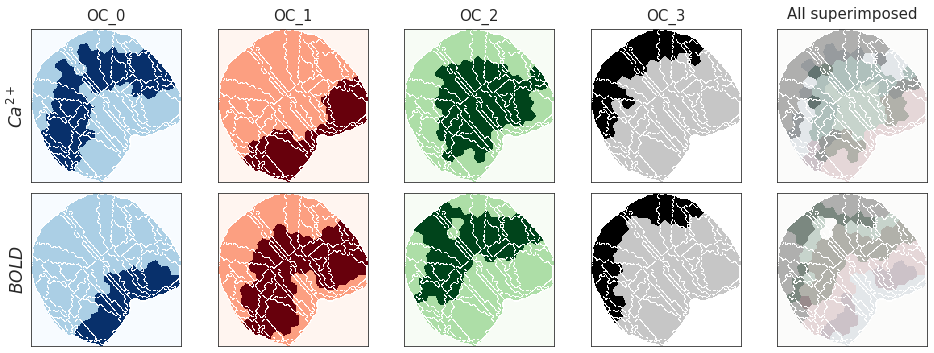

In [32]:
sns.set_style('white')
fig, axes = plt.subplots(2, num_comm + 1, figsize=(13.5, 5))

for comm_idx in range(num_comm):
    for i in range(2):
        cmap = cmaps[comm_idx]
        comm_list = svinet['community'][comm_idx] if i == 0 else svinet_bp['community'][mapping[comm_idx]]
        
        x = np.ones(load['atlas_kmeans'].shape) * -1
        y = np.ones(load['atlas_kmeans'].shape) * -1
        x[load['mask']] = 0.
        for node in comm_list:
            region_id = node_labels[node]
            x[load['atlas_kmeans'] == region_id] = 2
            y[load['atlas_kmeans'] == region_id] = 2
        
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        axes[i, comm_idx].imshow(data2plt, cmap=cmap, interpolation='none')
        axes[i, comm_idx].set_xticks([])
        axes[i, comm_idx].set_yticks([])

        data2plt = np.ma.masked_where(atls_org['contour'], y)
        axes[i, -1].imshow(data2plt, cmap=cmap, interpolation='none', alpha=0.3)
        axes[i, -1].set_xticks([])
        axes[i, -1].set_yticks([])
        
        if i == 0:
            axes[i, comm_idx].set_title('OC_{:d}'.format(comm_idx), fontsize=15, y=1.02)
            axes[i, -1].set_title('All superimposed', fontsize=15, y=1.03)
            
        if comm_idx == 0:
            axes[0, comm_idx].set_ylabel('$Ca^{2+}$', fontsize=17)
            axes[1, comm_idx].set_ylabel('$BOLD$', fontsize=17)

fig.tight_layout()
plt.show()

In [33]:
mapping = {
    0: 2,
    1: 0,
    2: 1,
    3: 3,
    # 4: 3,
}

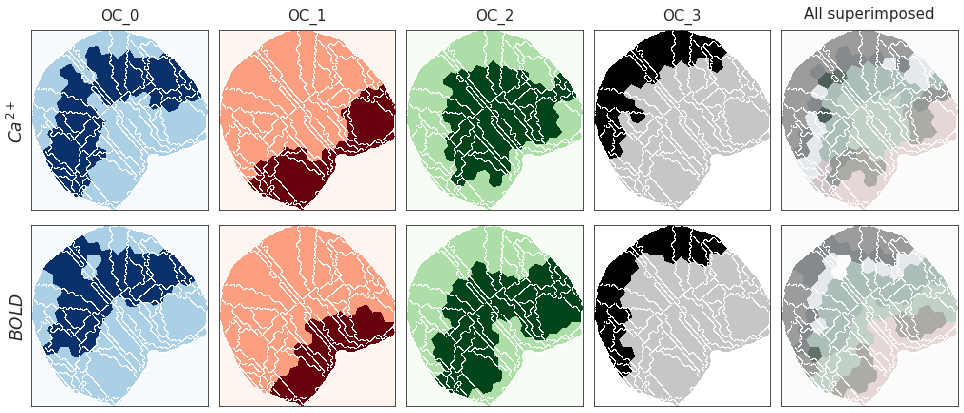

In [98]:
sns.set_style('white')
fig, axes = plt.subplots(2, num_comm + 1, figsize=(13.5, 6))

for comm_idx in range(num_comm):
    for i in range(2):
        cmap = cmaps[comm_idx]
        comm_list = svinet['community'][comm_idx] if i == 0 else svinet_bp['community'][mapping[comm_idx]]
        
        x = np.ones(load['atlas_kmeans'].shape) * -1
        y = np.ones(load['atlas_kmeans'].shape) * -1
        x[load['mask']] = 0.
        for node in comm_list:
            region_id = node_labels[node]
            x[load['atlas_kmeans'] == region_id] = 2
            y[load['atlas_kmeans'] == region_id] = 2
        
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        axes[i, comm_idx].imshow(data2plt, cmap=cmap, interpolation='none')
        axes[i, comm_idx].set_xticks([])
        axes[i, comm_idx].set_yticks([])

        data2plt = np.ma.masked_where(atls_org['contour'], y)
        axes[i, -1].imshow(data2plt, cmap=cmap, interpolation='none', alpha=1.5/num_comm)
        axes[i, -1].set_xticks([])
        axes[i, -1].set_yticks([])
        
        if i == 0:
            axes[i, comm_idx].set_title('OC_{:d}'.format(comm_idx), fontsize=15, y=1.02)
            axes[i, -1].set_title('All superimposed', fontsize=15, y=1.03)
            
        if comm_idx == 0:
            axes[0, comm_idx].set_ylabel('$Ca^{2+}$', fontsize=17)
            axes[1, comm_idx].set_ylabel('$BOLD$', fontsize=17)

fig.tight_layout()
fig.savefig('comms_cortex_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

In [99]:
# pred membership probabilities
pi_pred = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T
pi_pred_bp = np.concatenate([np.reshape(x, (1, -1)) for x in svinet_bp['membership'].values()]).T

pi_pred_cfg = np.concatenate([np.reshape(x, (1, -1)) for x in svinet_cfg['membership'].values()]).T
pi_pred_bp_cfg = np.concatenate([np.reshape(x, (1, -1)) for x in svinet_bp_cfg['membership'].values()]).T

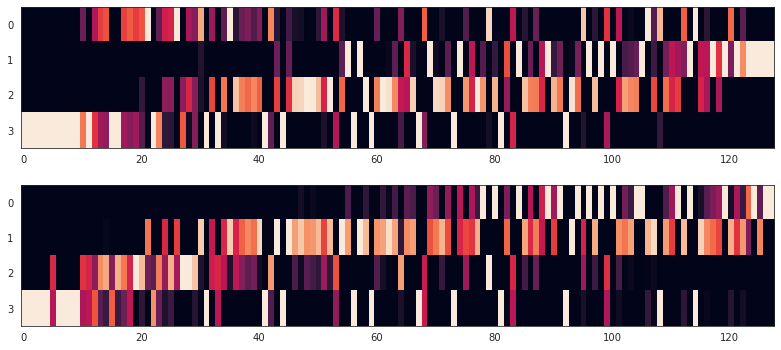

In [100]:
plt.figure(figsize=(13.5, 6))

plt.subplot(211)
plt.imshow(pi_pred, aspect=6, interpolation='none')

plt.subplot(212)
plt.imshow(pi_pred_bp, aspect=6, interpolation='none')

In [101]:
from sklearn.metrics.pairwise import cosine_similarity

In [102]:
cos_sim = cosine_similarity(pi_pred, pi_pred_bp)
print(np.round(cos_sim, decimals=1), '\n')

thres = 0.2
similarity = dict()
for true_idx in range(num_comm):
    sim_vec = np.where(cos_sim[true_idx] >= thres)[0]
    sim_vec = [x for _, x in sorted(zip(cos_sim[true_idx][sim_vec], sim_vec), reverse=True)]
    similarity[true_idx] = list(sim_vec)
print(similarity)

[[0.  0.4 0.6 0.3]
 [0.8 0.4 0.  0. ]
 [0.3 0.8 0.3 0. ]
 [0.  0.  0.4 0.9]] 

{0: [2, 1, 3], 1: [0, 1], 2: [1, 0, 2], 3: [3, 2]}


In [103]:
mapping

{0: 2, 1: 0, 2: 1, 3: 3}

In [104]:
# mapping = {i: sim[0] for i, sim in similarity.items()}
# mapping = {0: 2, 1: 3, 2: 0, 3: 4, 4: 1}
# pi_pred_bp = pi_pred_bp[list(mapping.values())]



In [105]:
cos_sim = cosine_similarity(pi_pred, pi_pred_bp[list(mapping.values())])

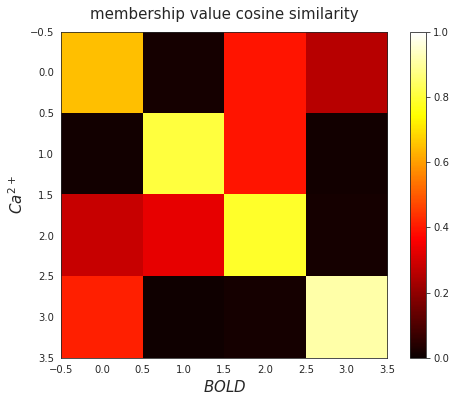

In [106]:
plt.figure(figsize=(8, 6))
plt.imshow(cos_sim, vmin=0, vmax=1, cmap='hot', interpolation='none')
plt.xlabel('$BOLD$', fontsize=15)
plt.ylabel('$Ca^{2+}$', fontsize=15)
plt.title('membership value cosine similarity', fontsize=15, y=1.02)
plt.colorbar()
plt.savefig('memship_cossim_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')

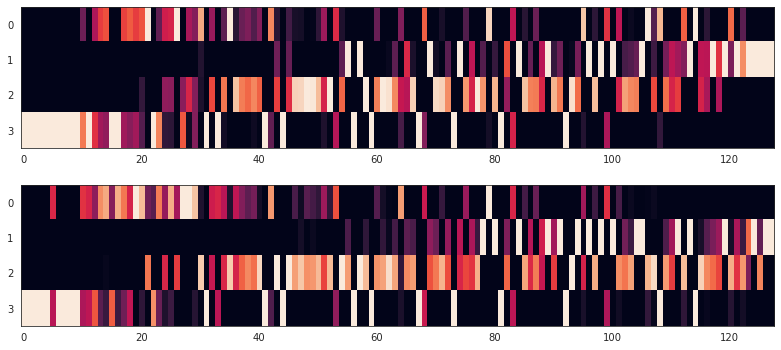

In [107]:
plt.figure(figsize=(13.5, 6))

plt.subplot(211)
plt.imshow(pi_pred, aspect=6, interpolation='none')

plt.subplot(212)
plt.imshow(pi_pred_bp[list(mapping.values())], aspect=6, interpolation='none')

plt.show()

In [108]:
n_nodes = g.order()
dict_list = []
for i in range(num_comm):
    data_dict = {
        'network_name': [network_name] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_pred[i],
    }
    dict_list.append(data_dict)
    
    data_dict = {
        'network_name': [network_name_bp] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_pred_bp[mapping[i]],
    }
    dict_list.append(data_dict)
df = pd.DataFrame.from_dict(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

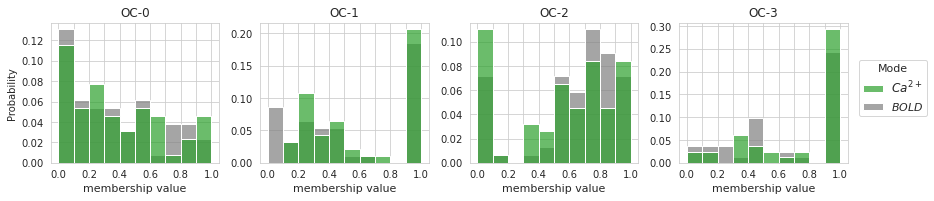

In [111]:
sns.set_style('whitegrid')
ncols = num_comm
nrows = int(np.ceil(num_comm / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 2.9))#, sharex='all')
axes = axes.reshape(nrows, ncols)

bins = np.linspace(0, 1, 11)
ticklabels = [np.round(item, decimals=1) if idx%2 == 0 else '' for idx, item in enumerate(bins)]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    union = set(svinet['community'][idx]).union(set(svinet_bp['community'][mapping[idx]]))
    selected_df = df.loc[(df.cluster == idx) & (df.node.isin(union))]
    hist = sns.histplot(
        data=selected_df,
        x='p',
        hue='network_name',
        stat='probability',
        # kde=True,
        alpha=0.7,
        bins=bins,
        # legend=True if idx == 2 else False,
        legend=True if idx == num_comm - 1 else False,
        palette=['C2', 'C7'],
        # line_kws={'lw': 2, 'alpha': 0.8},
        ax=axes[i, j],
    )
    leg = hist.get_legend()
    if leg is not None:
        plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=12)
        plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=11)
        plt.setp(leg.get_title(), text='Mode', fontsize=11)
        plt.setp(leg, bbox_to_anchor=(1.5, 0.77))
    axes[i, j].set_title('OC-{:d}'.format(idx), fontsize=12)
    axes[i, j].set_xticks(bins)
    axes[i, j].set_xticklabels(ticklabels)
    axes[i, j].set_xlabel('membership value', fontsize=11)
    
    if j > 0:
        axes[i, j].set_ylabel('')

fig.tight_layout()
fig.savefig('memship_hist_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

### Visualize memship values on cortex

In [112]:
run = 1
regions = {}
tot_num_regions = {}
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )
        if _load is None:
            continue
        _atlsorg = organize_atlas(_load)
        key = 'sub-SLC{:02d}_ses-{:d}'.format(subject, session)
        regions[key] = _atlsorg['regions']
        tot_num_regions[key] = len(_atlsorg['regions'])

common_regions = list(set.intersection(*[set(reg_dict.keys()) for reg_dict in regions.values()]))
common_regions = {k: config.region_labels[k] for k in sorted(common_regions)}
common_r = [item[2:] for item in common_regions.values() if item[:2] == 'R-']
common_l = [item[2:] for item in common_regions.values() if item[:2] == 'L-']
common_global = set(common_r).intersection(common_l)
common_regions = {k: v for k, v in common_regions.items() if v[2:] in common_global}
len(common_regions)

44

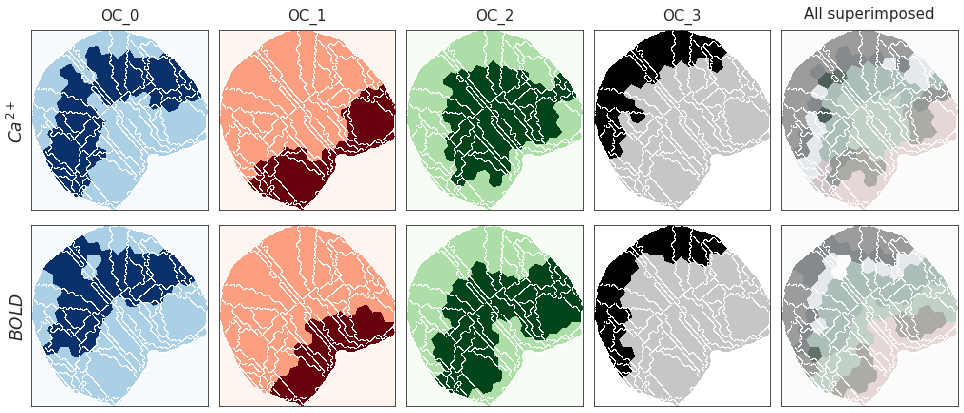

In [113]:
sns.set_style('white')
fig, axes = plt.subplots(2, num_comm + 1, figsize=(13.5, 6))

for comm_idx in range(num_comm):
    for i in range(2):
        cmap = cmaps[comm_idx]
        comm_list = svinet['community'][comm_idx] if i == 0 else svinet_bp['community'][mapping[comm_idx]]
        
        x = np.ones(load['atlas_kmeans'].shape) * -1
        y = np.ones(load['atlas_kmeans'].shape) * -1
        x[load['mask']] = 0.
        for node in comm_list:
            region_id = node_labels[node]
            x[load['atlas_kmeans'] == region_id] = 2
            y[load['atlas_kmeans'] == region_id] = 2
        
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        axes[i, comm_idx].imshow(data2plt, cmap=cmap, interpolation='none')
        axes[i, comm_idx].set_xticks([])
        axes[i, comm_idx].set_yticks([])

        data2plt = np.ma.masked_where(atls_org['contour'], y)
        axes[i, -1].imshow(data2plt, cmap=cmap, interpolation='none', alpha=1.5/num_comm)
        axes[i, -1].set_xticks([])
        axes[i, -1].set_yticks([])
        
        if i == 0:
            axes[i, comm_idx].set_title('OC_{:d}'.format(comm_idx), fontsize=15, y=1.02)
            axes[i, -1].set_title('All superimposed', fontsize=15, y=1.03)
            
        if comm_idx == 0:
            axes[0, comm_idx].set_ylabel('$Ca^{2+}$', fontsize=17)
            axes[1, comm_idx].set_ylabel('$BOLD$', fontsize=17)

fig.tight_layout()
# fig.savefig('comms_cortex_OC{:d}.pdf'.format(num_comm), dpi=300, bbox_inches='tight')
plt.show()

## Node centralities

In [114]:
from scipy import special as sp_special

ent = sp_special.entr(pi_pred).sum(0) / np.log(num_comm)
ent_bp = sp_special.entr(pi_pred_bp).sum(0) / np.log(num_comm)

ent_cfg = sp_special.entr(pi_pred_cfg).sum(0) / np.log(num_comm)
ent_bp_cfg = sp_special.entr(pi_pred_bp_cfg).sum(0) / np.log(num_comm)

In [116]:
selected_graphs = {'ca': g, 'bold': g_bp}
selected_graphs_cfg = {'ca': g_cfg, 'bold': g_bp_cfg}

In [117]:
centralities = {}
centralities_cfg = {}

for key in ['ca', 'bold']:
    # real
    _graph = selected_graphs[key]
    degree = nx.degree_centrality(_graph)
    closeness = nx.closeness_centrality(_graph, distance='weight')
    betweenness = nx.betweenness_centrality(_graph, weight='weight')
    eigenvector = nx.eigenvector_centrality(_graph, weight='weight')

    centralities[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'entropy': {i: ent[i]/max(ent) for i in range(g.order())},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
    }
    for comm_idx in range(num_comm):
        memship_vec = pi_pred[comm_idx] if key == 'ca' else pi_pred_bp[mapping[comm_idx]]
        memship_dict = {node: memship_vec[node]/max(memship_vec) for node in _graph.nodes}
        centralities[key].update({'OC_{:d}_memship'.format(comm_idx): memship_dict})

    # cfg
    _cfg = selected_graphs_cfg[key]
    degree = nx.degree_centrality(_cfg)
    closeness = nx.closeness_centrality(_cfg, distance='weight')
    betweenness = nx.betweenness_centrality(_cfg, weight='weight')
    eigenvector = nx.eigenvector_centrality(_cfg, weight='weight')

    centralities_cfg[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'entropy': {i: ent_cfg[i]/max(ent_cfg) for i in range(g.order())},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
    }
    for comm_idx in range(num_comm):
        memship_vec = pi_pred_cfg[comm_idx] if key == 'ca' else pi_pred_bp_cfg[mapping[comm_idx]]
        memship_dict = {node: memship_vec[node]/max(memship_vec) for node in _cfg.nodes}
        centralities_cfg[key].update({'OC_{:d}_memship'.format(comm_idx): memship_dict})

In [118]:
key = 'ca'

centralities_cortex = {}
for lbl, centrality_d in centralities[key].items():
    x = np.ones(load['atlas_kmeans'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas_kmeans'] == region_id] = value
    centralities_cortex[lbl] = x

centralities_cortex_cfg = {}
for lbl, centrality_d in centralities_cfg[key].items():
    x = np.ones(load['atlas_kmeans'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas_kmeans'] == region_id] = value
    centralities_cortex_cfg[lbl] = x

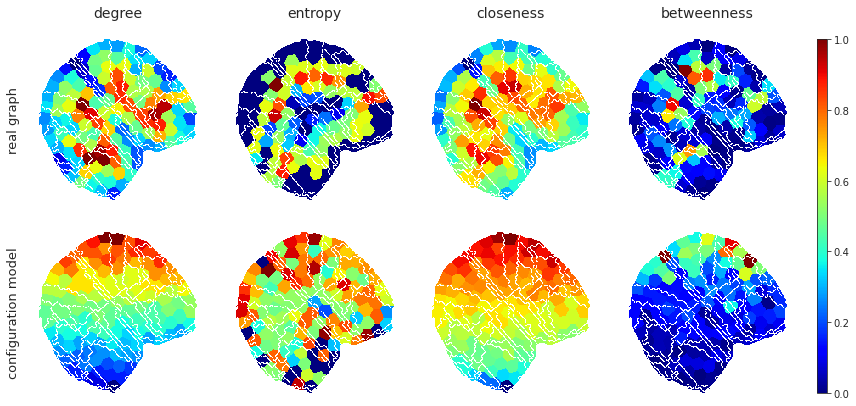

In [130]:
sns.set_style('white')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 6.5))
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(centralities_cortex.keys()):
    if 'memship' in lbl:
        continue
    for i in range(2):
        x = centralities_cortex[lbl] if i == 0 else centralities_cortex_cfg[lbl]
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')

        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if i == 0:
            axes[i, j].set_title('{:s}'.format(lbl), fontsize=14, y=1.1)
            
        if j == 0:
            axes[0, j].set_ylabel('real graph\n', fontsize=13)
            axes[1, j].set_ylabel('configuration model\n', fontsize=13)

# msg = 'Node centralities,   top row: real graph,   bottom row: configuration model'
#fig.suptitle(msg, fontsize=15, y=0.98)

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.2 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=cax, orientation="vertical")
fig.savefig('centralities_cortex_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

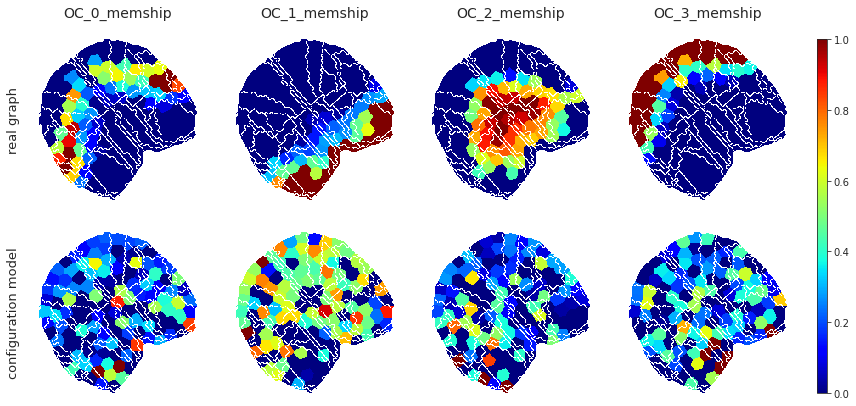

In [131]:
sns.set_style('white')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 6.5))
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(centralities_cortex.keys()):
    if 'memship' not in lbl:
        continue
    j -= 4
    for i in range(2):
        x = centralities_cortex[lbl].copy() if i == 0 else centralities_cortex_cfg[lbl].copy()
        x[x < 0.01] = 0
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')
        # plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)
        
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if i == 0:
            axes[i, j].set_title('{:s}'.format(lbl), fontsize=14, y=1.1)
            
        if j == 0:
            axes[0, j].set_ylabel('real graph\n', fontsize=13)
            axes[1, j].set_ylabel('configuration model\n', fontsize=13)

# msg = 'Node centralities,   top row: real graph,   bottom row: configuration model'
# fig.suptitle(msg, fontsize=15, y=0.98)
# fig.tight_layout()

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.2 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=cax, orientation="vertical")
fig.savefig('memships_cortex_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

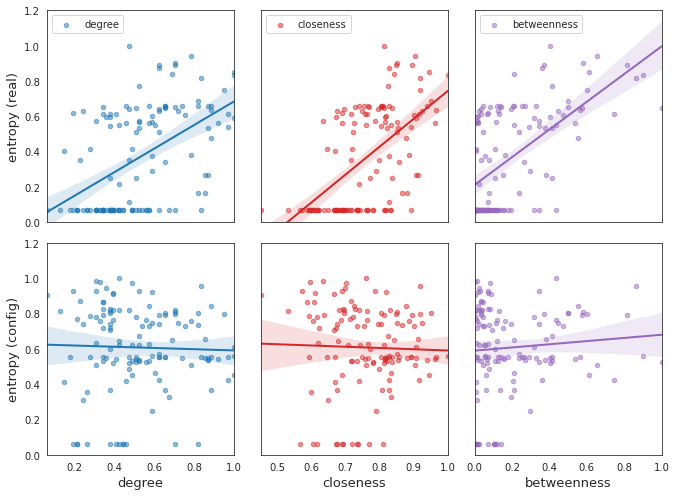

In [129]:
key = 'ca'
_lbls = {
    'degree': 'C0',
    'closeness': 'C3',
    'betweenness': 'C4',
    # 'eigenvector': 'C5',
}

sns.set_style('white')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(9.5, 7), sharey='row', sharex='col')
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(_lbls):
    x = list(centralities[key][lbl].values())
    for i in range(2):
        if i == 0:
            y = list(centralities[key]['entropy'].values())
        else:
            y = list(centralities_cfg[key]['entropy'].values())
        sns.regplot(
            x=x,
            y=y,
            color=_lbls[lbl],
            label=lbl,
            x_ci='sd',
            line_kws={'lw': 2},
            scatter_kws={'alpha': 0.5, 's': 20,},
            ax=axes[i, j],
        )
        axes[i, j].set_ylim(0, 1.2)
        if i == 0:
            axes[i, j].legend(loc='upper left')
        else:
            axes[i, j].set_xlabel(lbl, fontsize=13)
            
        
    if j == 0:
        axes[0, j].set_ylabel('entropy (real)', fontsize=13)
        axes[1, j].set_ylabel('entropy (config)', fontsize=13)

fig.tight_layout()
fig.savefig('centralities_regscatter_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()